In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [123]:
arff_file = arff.loadarff('./dataset_31_credit-g.arff')
df = pd.DataFrame(arff_file[0])
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


In [124]:
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

df['monthly_payment_amount'] = df['credit_amount'] / df['duration']
df['is_short_term'] = pd.cut(df['duration'], bins=[0, 18, 999], labels=['yes', 'no'])

In [138]:
ordinal_columns = [
    "checking_status",
    "savings_status",
    "employment",
]

nominal_columns = [
    "credit_history",
    "purpose",
    "property_magnitude",
    "other_payment_plans",
    "housing",
    "is_short_term",
]

numeric_columns = [
    "age",
    "duration",
    "credit_amount",
    "monthly_payment_amount"
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            'process_nominal_columns',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]),
            nominal_columns
        ),
        (
            'process_ordinal_columns',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder())
            ]),
            ordinal_columns
        ),
        (
            'process_numeric_columns',
            Pipeline(steps=[
                ('nan_imputer', SimpleImputer(strategy='median')),
                # ('scaler', StandardScaler())
            ]),
            numeric_columns
        ),
    ]
)

In [139]:
y = (df['class'] == 'good').astype(int) # Binary encoding for target
X = preprocessor.fit_transform(df)
X.shape

(1000, 34)

In [140]:
# split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training rows: {len(X_train)}')
print(f'Test rows: {len(X_test)}')

Training rows: 800
Test rows: 200


In [141]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'random_forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [1, 10, 25, 50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': range(1, 20, 2),
            'criterion': ['gini', 'entropy', 'log_loss']
        },
        'grid': None
    },
    'gradient_boosted_trees': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [1, 10, 25, 50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': range(1, 20, 2),
            'criterion': ['friedman_mse', 'squared_error'],
        },
        'grid': None
    },
    'extra_trees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'n_estimators': [1, 10, 25, 50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': range(1, 20, 2),
            'criterion': ['gini', 'entropy', 'log_loss']
        },
        'grid': None
    }
}

In [142]:
for model_name, entry in models.items():
    grid = GridSearchCV(entry['model'], entry['params'], cv=cv, scoring='accuracy')
    grid.fit(X_train, y_train)
    scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')

    print(model_name)
    print(f"\tbest params: {grid.best_params_}")
    print(f"\tbest score: {grid.best_score_}")
    print(f"\tscore mean: {scores.mean()}")
    print(f"\tscore std: {scores.std()}")

    entry['grid'] = grid

/Users/chanlee/.pyenv/versions/3.11.2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


random_forest
	best params: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
	best score: 0.7575000000000001
	score mean: 0.7575000000000001
	score std: 0.025124689052802213


/Users/chanlee/.pyenv/versions/3.11.2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


gradient_boosted_trees
	best params: {'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200}
	best score: 0.75125
	score mean: 0.75125
	score std: 0.02942150573984954
extra_trees
	best params: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 25}
	best score: 0.73125
	score mean: 0.73125
	score std: 0.030872722588071177


In [143]:
models['random_forest']['grid']

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 20, 2),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1, 10, 25, 50, 100, 200]},
             scoring='accuracy')

In [144]:
best_model = models['random_forest']['grid'].best_estimator_

assert len(best_model.feature_importances_) == len(preprocessor.get_feature_names_out())

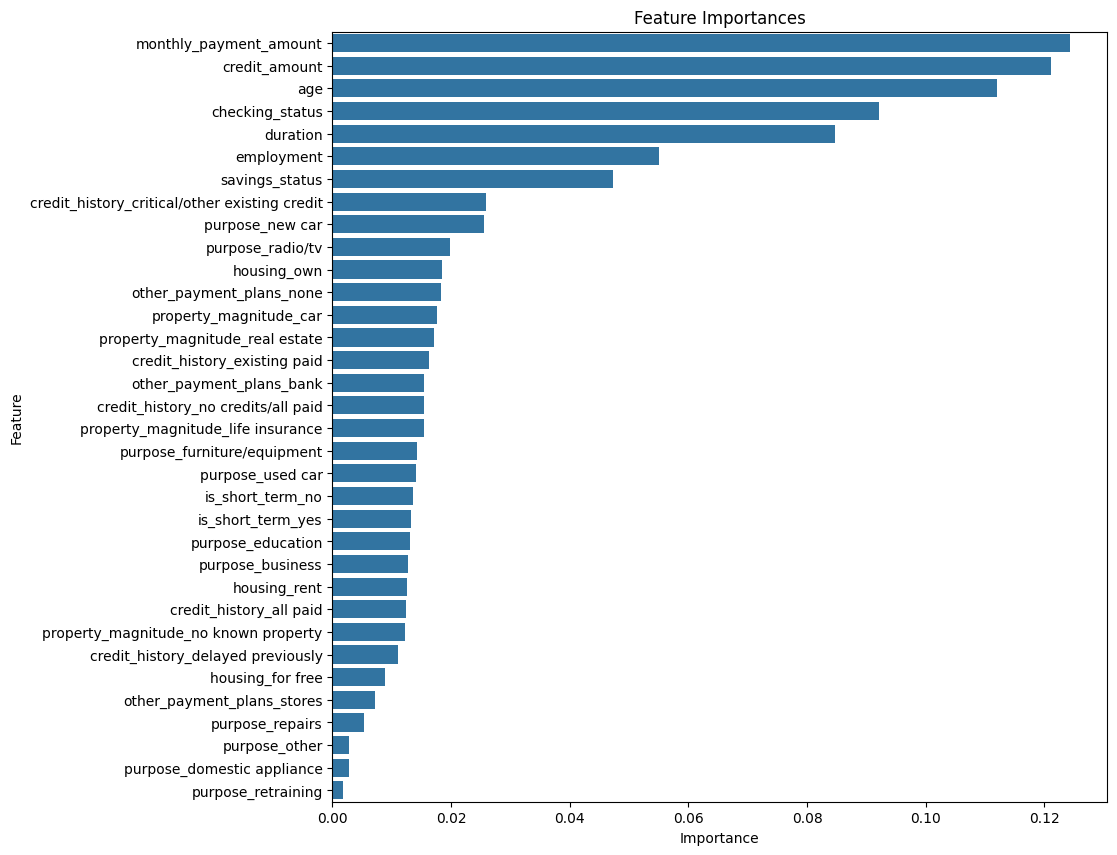

In [145]:
feature_names = list(map(lambda feature_name: feature_name[feature_name.find("__") + 2:], preprocessor.get_feature_names_out()))

df_importance = pd.DataFrame({
    'importance': best_model.feature_importances_,
    'feature': feature_names
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=df_importance
)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [146]:
best_model.estimators_

[DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                        random_state=787846414),
 DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                        random_state=996406378),
 DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                        random_state=1201263687),
 DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                        random_state=423734972),
 DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
             

In [147]:
from sklearn.tree import export_text

data_point = X_train[[0]]
print(pd.DataFrame({
    'feature': feature_names,
    'value': data_point[0],
}))

tree = best_model.estimators_[0]

node_indicator = tree.decision_path(data_point)

feature = tree.tree_.feature
threshold = tree.tree_.threshold
tree_value = tree.tree_.value

print("Decision path for the first tree:")
for node_id in node_indicator.indices:
    if feature[node_id] != -2:  # If not a leaf node
        feature_name = feature_names[feature[node_id]]
        threshold_value = threshold[node_id]
        value = data_point[0, feature[node_id]]
        decision = f"Feature {feature_name} <= {threshold_value}" if value <= threshold_value else f"Feature {feature_name} > {threshold_value}"
        print(f"Node {node_id}: {decision}")
    else:  # Leaf node
        class_distribution = tree_value[node_id].flatten()
        predicted_class = np.argmax(class_distribution)
        print(f"Leaf Node {node_id}: Class Distribution = {class_distribution}, Predicted Class = {predicted_class}")

# Optional: Get the overall prediction from the RandomForest model
final_prediction = best_model.predict(data_point)[0]
print(f"\nFinal Prediction from RandomForestClassifier: {final_prediction}")

# Optional: Export a text representation of the tree
tree_rules = export_text(tree, feature_names=feature_names)
print("\nRules of the first tree:\n", tree_rules)

                                          feature        value
0                         credit_history_all paid     0.000000
1   credit_history_critical/other existing credit     0.000000
2               credit_history_delayed previously     1.000000
3                    credit_history_existing paid     0.000000
4              credit_history_no credits/all paid     0.000000
5                                purpose_business     1.000000
6                      purpose_domestic appliance     0.000000
7                               purpose_education     0.000000
8                     purpose_furniture/equipment     0.000000
9                                 purpose_new car     0.000000
10                                  purpose_other     0.000000
11                               purpose_radio/tv     0.000000
12                                purpose_repairs     0.000000
13                             purpose_retraining     0.000000
14                               purpose_used car     0

## Evaluation on test data

Random Forest
	Accuracy: 0.77
	Precision: 0.7745664739884393
	Recall: 0.950354609929078
	TPR: 0.950354609929078
	FPR: 0.6610169491525424


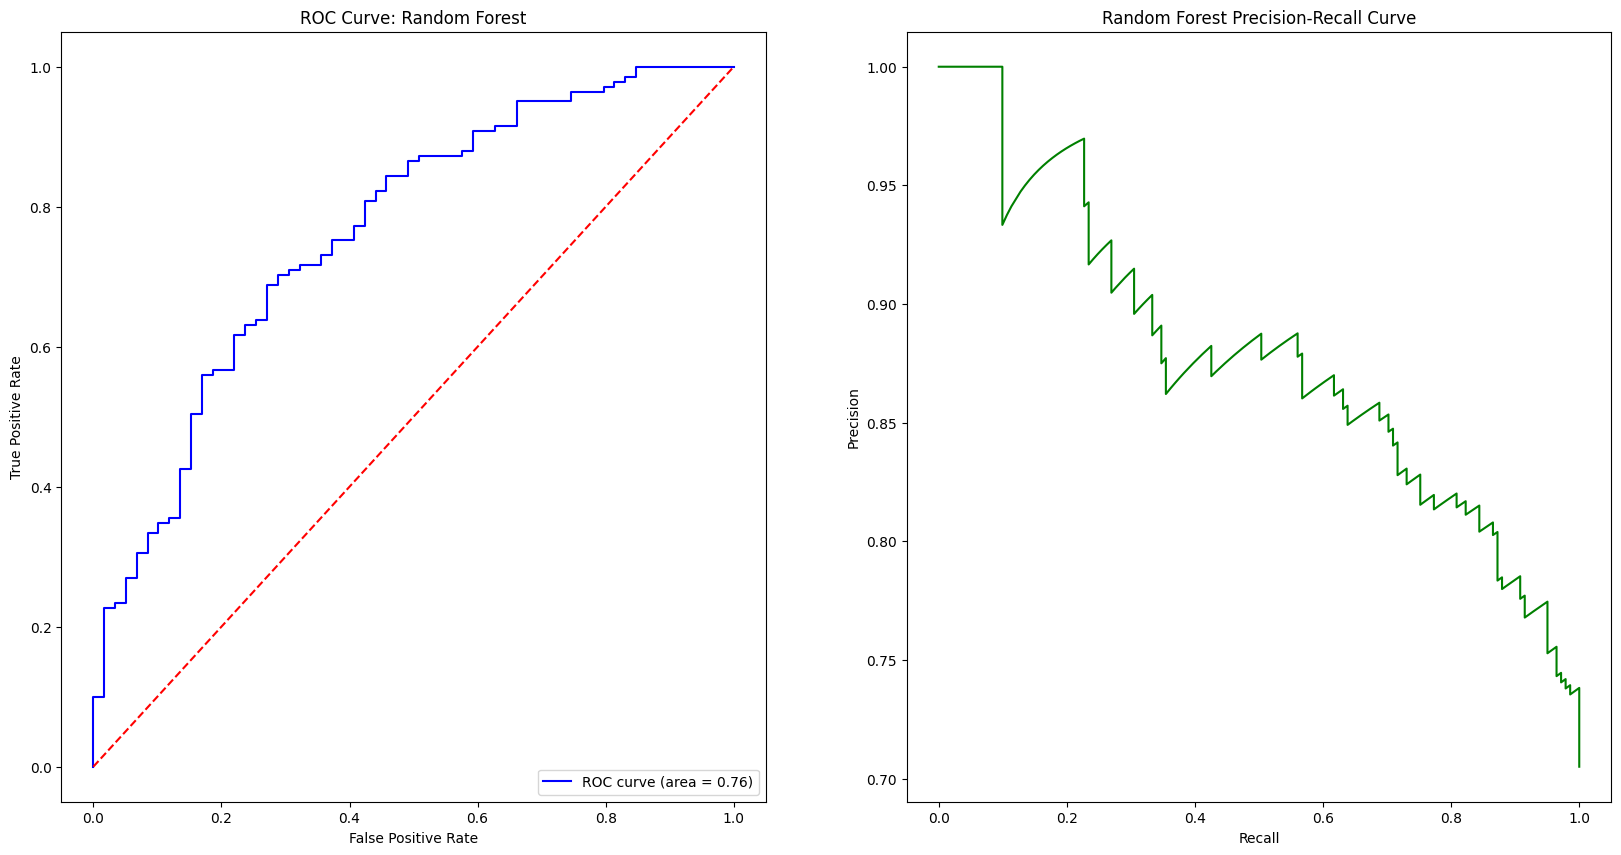

In [112]:
import importlib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import helpers as _helpers

importlib.reload(helpers)

# Evaluate on the validation set

y_pred = best_model.predict(X_test)
y_pred = np.round(y_pred)
y_scores = best_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(20, 10))
_helpers.display_metrics('Random Forest', y_test, y_pred, y_scores)

## Applying Cost Matrix

In [120]:
from sklearn.metrics import confusion_matrix

# Cost matrix
cost_fp = 5  # Cost of a False Positive
cost_fn = 1  # Cost of a False Negative

# Assuming y_test (true labels) and y_pred (predicted labels) are defined
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

total_cost = (fp * cost_fp) + (fn * cost_fn)

print(f"Total Cost: {total_cost}")

Total Cost: 250


Optimal Threshold: 0.75
Minimum Total Cost: 114


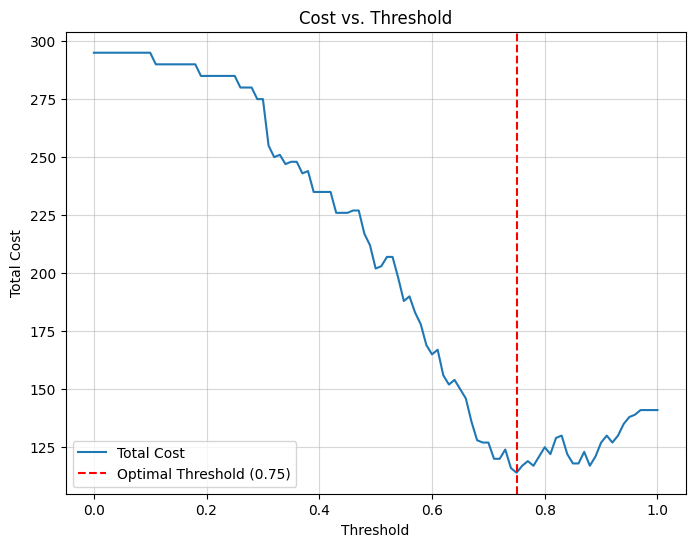

In [121]:
y_proba = best_model.predict_proba(X_test)[:, 1]

def calculate_cost(y_true, y_proba, threshold, cost_fp, cost_fn):
    y_pred = (y_proba > threshold).astype(int)  # Apply threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # Confusion matrix
    total_cost = (fp * cost_fp) + (fn * cost_fn)  # Total cost
    return total_cost

thresholds = np.arange(0.0, 1.01, 0.01)
costs = [calculate_cost(y_test, y_proba, t, cost_fp, cost_fn) for t in thresholds]

optimal_threshold = thresholds[np.argmin(costs)]
min_cost = min(costs)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Minimum Total Cost: {min_cost}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, costs, label="Total Cost")
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f"Optimal Threshold ({optimal_threshold:.2f})")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Cost vs. Threshold")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

Random Forest
	Accuracy: 0.63
	Precision: 0.8850574712643678
	Recall: 0.5460992907801419
	TPR: 0.5460992907801419
	FPR: 0.1694915254237288


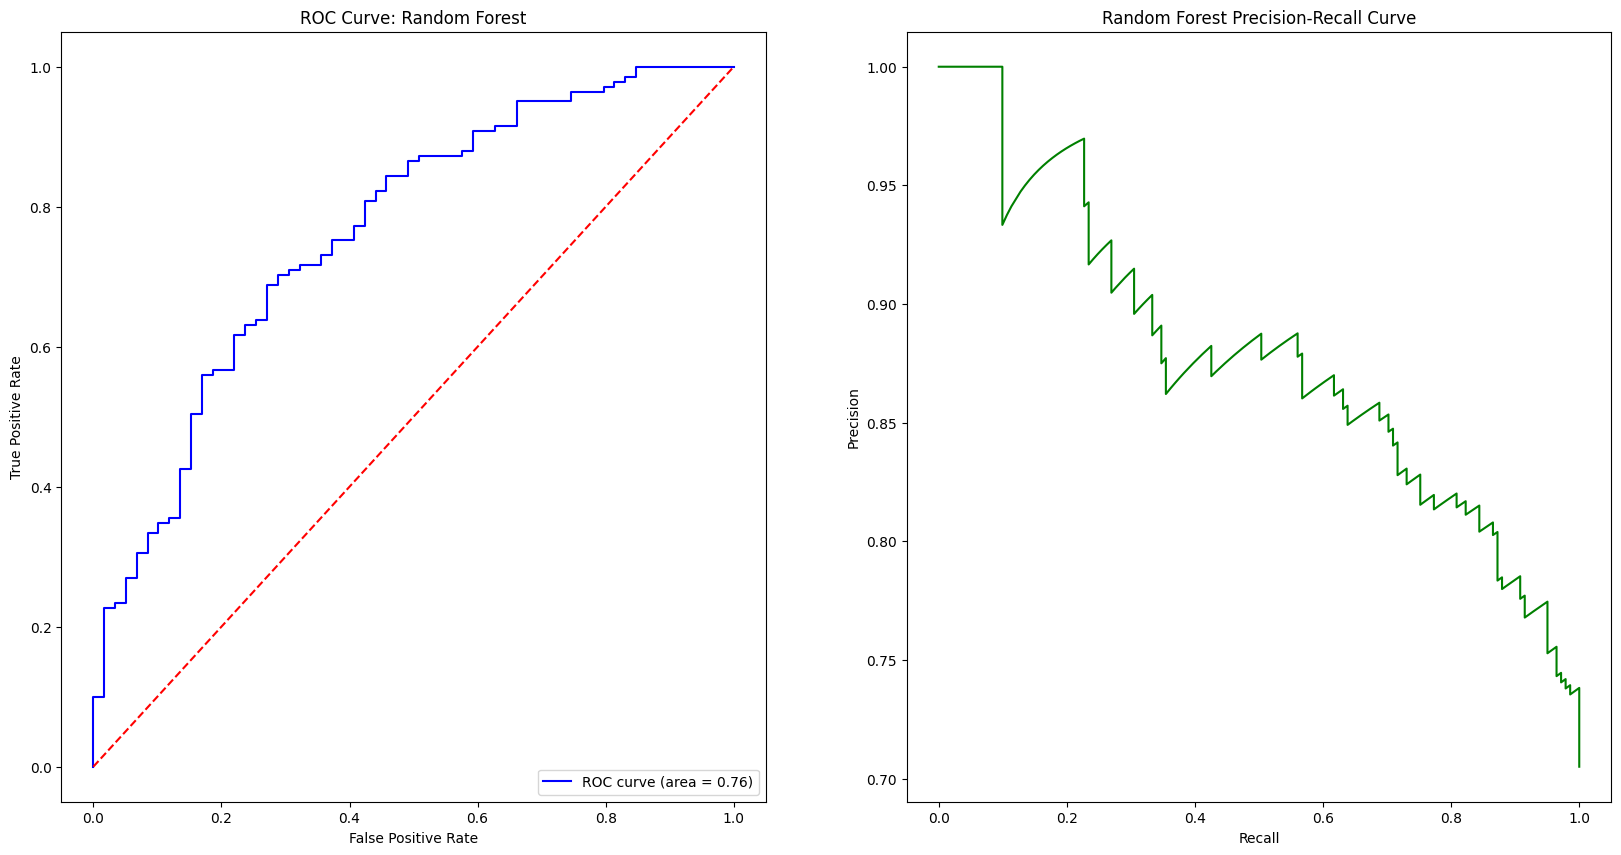

In [122]:
y_scores = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.75).astype(int)

plt.figure(figsize=(20, 10))
_helpers.display_metrics('Random Forest', y_test, y_pred, y_scores)